In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import pandas as pd

import copy
from tqdm import tqdm_notebook

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

print_dict = {1: ' ', 0: 'o', 2: 'x'}
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [2]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

def get_move(policy, s, actions, random=False):
    if random:
        return np.random.randint(len(actions))
    else:
        return policy(s, actions)
    
def print_board(observation, N_ROWS, N_COLS):
    board = np.zeros((N_ROWS, N_COLS))
    for k in range(len(observation[0])):
        board[int(k / N_COLS), k % N_COLS] = observation[0][k]
    for a in board:
        print('|', ''.join([print_dict[i] for i in a]), '|')
        
def play_test_game(env, pi1, pi2, random_crosses=True, random_naughts=True):
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_move(pi1, s, actions, random=random_crosses)
        else:
            a = get_move(pi2, s, actions, random=random_naughts)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            
        if reward == -1:
            print("Нолики выиграли!")
    print_board(observation, N_ROWS, N_COLS)

In [3]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)

play_test_game(env, None, None, random_crosses=True, random_naughts=True)

In [4]:
class RandomStrategy():

    def __init__(self):
        pass

    def selectMove(self, actions, s, value):
        return actions[np.random.randint(0, len(actions))]
    
    def reward(self, rewardValue):
        pass
    
    def resetStatesHistory(self):
        pass

class QStrategy():
    def __init__(self, learningRate = 0.2, decay = 0.8):
        self.learningRate = learningRate
        self.decay = decay
        self.states = {}
        self.states_history = []
        self.num_step = 0
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200

    def selectMove(self, actions, s, player_value):
        sample = np.random.rand()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final
                                         ) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample <= eps_threshold:    
        #probability = np.random.rand()
        #if probability <= self.exploratory_rate:
            bestMove = actions[np.random.randint(0, len(actions))]
        else:
            maxValue = float("-inf")
            bestMove = actions[0]
            for a in actions:#over all actions
                st_copy = copy.deepcopy(s)
                i = a[0] * N_COLS + a[1]
                st_copy = st_copy[:i] + player_value + st_copy[i + 1:]#next state
                value = self.states.get(st_copy, 0)
                if value > maxValue:
                    maxValue = value
                    bestMove = a
            
        st_copy = copy.deepcopy(s)
        i = bestMove[0] * N_COLS + bestMove[1]
        st_copy = st_copy[:i] + player_value + st_copy[i + 1:]
        self.states_history.append(st_copy)
        return bestMove

    def reward(self, rewardValue):
        
        for stateHash in reversed(self.states_history):
            if self.states.get(stateHash) is None:
                self.states[stateHash] = 0
            self.states[stateHash] += self.learningRate * (self.decay * rewardValue - self.states[stateHash])
            rewardValue = self.states[stateHash]

    def resetStatesHistory(self):
        self.states_history = []
        

class Player:
    def __init__(self, value, strategy):
        self.value = value
        self.strategy = strategy

    def getValue(self):
        return self.value

    def move(self, actions, state):
        return self.strategy.selectMove(actions, state, self.value)

    def reward(self, rewardValue):
        self.strategy.reward(rewardValue)

    def resetStatesHistory(self):
        self.strategy.resetStatesHistory()

In [5]:
class Game:
    def __init__(self, strategy1, strategy2, env):
        self.player1 = Player("2", strategy1)
        self.player2 = Player("0", strategy2)
        self.env = env
        self.playerXWins = 0
        self.playerOWins = 0
        self.draws = 0
        
    def playGame(self, is_train_1 = True, is_train_2 = True):
        done = False
        self.env.reset()
        while not done:
            s, actions = self.env.getHash(), self.env.getEmptySpaces()
            if env.curTurn == 1:
                playerToMove = self.player1
            else:
                playerToMove = self.player2
            selectedMove = playerToMove.move(actions, copy.deepcopy(s))
            observation, reward, done, info = self.env.step(selectedMove)
        
        if is_train_1:
            if self.player1.value == str(reward + 1):
                self.player1.reward(1)
            elif self.player2.value == str(reward + 1):
                self.player1.reward(-1)
            else:
                self.player1.reward(0.)
        if is_train_2:
            if self.player1.value == str(reward + 1):
                self.player2.reward(-1)
            elif self.player2.value == str(reward + 1):
                self.player2.reward(1)
            else:
                self.player2.reward(0.)
            
            self.player1.resetStatesHistory()
            self.player2.resetStatesHistory()
            
        return reward
            
    def playManyGames(self, numberOfGames, is_train_1 = True, is_train_2 = True):
        self.playerXWins = 0
        self.playerOWins = 0
        self.draws = 0
        numberOfGamesAxis = []
        playerXWinsAxis = []
        playerOWinsAxis = []
        drawsAxis = []
        for i in range(numberOfGames):
            totalWins = self.playerXWins + self.playerOWins + self.draws
            reward = self.playGame(is_train_1, is_train_2)
            if self.player1.value == str(reward + 1):
                self.playerXWins = self.playerXWins + 1
            elif self.player2.value == str(reward + 1):
                self.playerOWins = self.playerOWins + 1
            else:
                self.draws = self.draws + 1
            numberOfGamesAxis.append(i + 1)
            playerXWinsAxis.append(self.playerXWins)
            playerOWinsAxis.append(self.playerOWins)
            drawsAxis.append(self.draws)

        statistics = {"Games": numberOfGamesAxis,
                     "X": playerXWinsAxis,
                     "O": playerOWinsAxis,
                     "Draws": drawsAxis}
        return pd.DataFrame(statistics, columns = ['Games', 'X', 'O', 'Draws'])

In [6]:
def plot_stats(stats, title = 'Random(X) vs Random(O)'):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.plot(stats.X / stats.iloc[:, 1:4].sum(1))
    plt.ylabel('cumulative share of X wins')
    plt.xlabel('number of games')
    plt.show()

### Обучим Q-стратегии для крестиков и для ноликов на доске 3х3.
Обучать будем следующим образом:   
Тренируем модель на 20 играх, затем оцениваем качество на 1000.   
Повторяем это несколько раз и каждый раз смотрим на то, как меняется качество.   

In [7]:
strategy1 = RandomStrategy()
strategy2 = QStrategy(learningRate = 0.3, decay = 0.8)
game = Game(strategy1, 
            strategy2, 
            env)
num_games_per_epoch = 20
results = []
for i in tqdm_notebook(range(200)):
    stats = game.playManyGames(num_games_per_epoch, True, True)
    stats = game.playManyGames(1000, False, False)
    stats = stats.tail(1)
    stats['epoch'] = i + 1
    results.append(stats)

<ipython-input-7-00485d69749a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(200)):


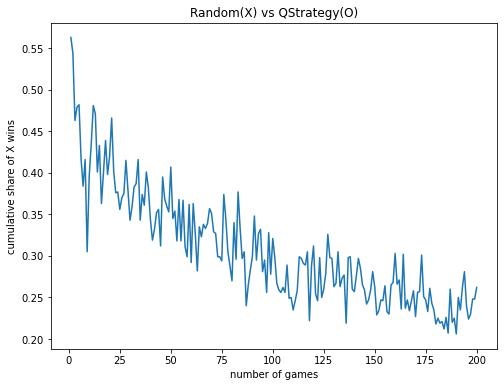

In [8]:
stats = pd.concat(results)
stats.index = stats.epoch
plot_stats(stats, title = 'Random(X) vs QStrategy(O)')

In [9]:
strategy1 = QStrategy(learningRate = 0.3, decay = 0.8)
strategy2 = RandomStrategy()
game = Game(strategy1, 
            strategy2, 
            env)
num_games_per_epoch = 20
results = []
for i in tqdm_notebook(range(200)):
    stats = game.playManyGames(num_games_per_epoch, True, True)
    stats = game.playManyGames(1000, False, False)
    stats = stats.tail(1)
    stats['epoch'] = i + 1
    results.append(stats)

<ipython-input-9-3453ae0c89ee>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(200)):


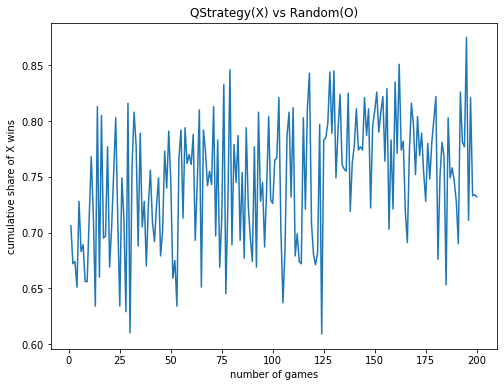

In [10]:
stats = pd.concat(results)
stats.index = stats.epoch
plot_stats(stats, title = 'QStrategy(X) vs Random(O)')

### Теперь обучим Q-стратегии для крестиков и для ноликов на доске 5х5.
Только теперь тренируем модель на 50 играх, а дальше все тоже самое.

In [11]:
N_ROWS, N_COLS, N_WIN = 5, 5, 4
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)

In [12]:
strategy1 = RandomStrategy()
strategy2 = QStrategy(learningRate = 0.3, decay = 0.8)
game = Game(strategy1, 
            strategy2, 
            env)
num_games_per_epoch = 50
results = []
for i in tqdm_notebook(range(200)):
    stats = game.playManyGames(num_games_per_epoch, True, True)
    stats = game.playManyGames(1000, False, False)
    stats = stats.tail(1)
    stats['epoch'] = i + 1
    results.append(stats)

<ipython-input-12-6a7b6642352b>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(200)):


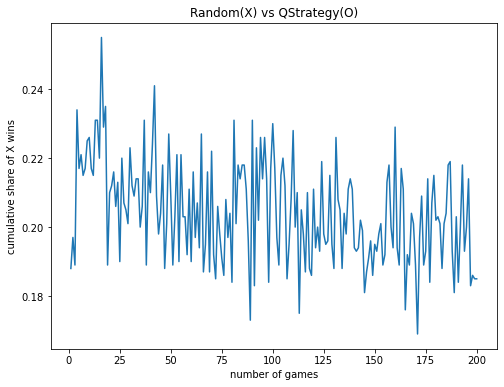

In [13]:
stats = pd.concat(results)
stats.index = stats.epoch
plot_stats(stats, title = 'Random(X) vs QStrategy(O)')

In [14]:
strategy1 = QStrategy(learningRate = 0.3, decay = 0.8)
strategy2 = RandomStrategy()
game = Game(strategy1, 
            strategy2, 
            env)
num_games_per_epoch = 50
results = []
for i in tqdm_notebook(range(200)):
    stats = game.playManyGames(num_games_per_epoch, True, True)
    stats = game.playManyGames(1000, False, False)
    stats = stats.tail(1)
    stats['epoch'] = i + 1
    results.append(stats)

<ipython-input-14-63876f8c393b>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(200)):


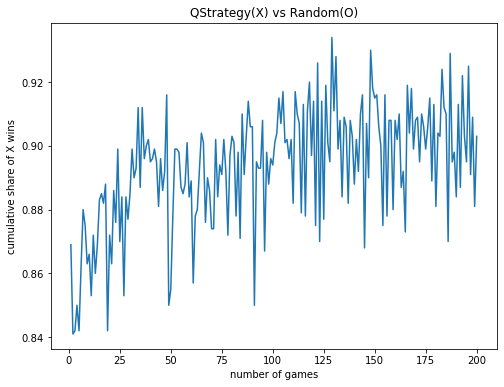

In [15]:
stats = pd.concat(results)
stats.index = stats.epoch
plot_stats(stats, title = 'QStrategy(X) vs Random(O)')

### Перейдем к экспериментам с DQN.
В качестве сетки будем использовать двухслойную сверточную сеть с батч-нормализацией и сразу же с Replay Memory.

In [16]:
def get_board(state):
    board = np.zeros((N_ROWS, N_COLS))
    for k in range(len(state)):
        board[int(k / N_COLS), k % N_COLS] = state[k]
    return board

def get_mask(actions):
    mask = np.zeros((N_ROWS, N_COLS)) - 100
    mask[actions[:,0],actions[:,1]] = 0
    return mask

In [17]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=True)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=True)
        self.bn2 = nn.BatchNorm2d(32)
        self.head = nn.Conv2d(32, 1, kernel_size=1, stride=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return F.relu(self.head(x))

In [18]:
class RandomPlayer:
    def __init__(self, value):
        self.value = value
    
    def getValue(self):
        return self.value
    
    def move(self, actions, state):
        return actions[np.random.randint(0, len(actions))]
    
    def store(self, transition):
        pass

    def train(self):
        pass

class DQN_Player:
    def __init__(self, value):
        self.value = value
        self.model = DQN()
        self.memory = ReplayMemory(1000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.gamma = 0.8
        self.batch_size = 64
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0

    def getValue(self):
        return self.value
    
    def select_greedy_action(self, state, actions):
        with torch.no_grad():
            x = self.model(torch.tensor(get_board(state).astype(np.float32)
                                       ).unsqueeze(0).unsqueeze(1)).squeeze(1)
        x = (x.squeeze(0).data.numpy() + get_mask(actions))
        return np.array(np.unravel_index(np.argmax(x, axis=None), x.shape))
        
    
    def select_action(self, state, actions):
        sample = np.random.rand()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final
                                         ) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, actions)
        else:
            return actions[np.random.randint(0, len(actions))]

    def move(self, actions, state):
        return self.select_action(state, actions)

    def store(self, transition):
        self.memory.store(transition)

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        
        pred = self.model(batch_state.unsqueeze(1)).squeeze(1)
        Q = []
        for i in range(self.batch_size):
            a = batch_action[i].data.numpy()
            Q.append(pred[i][a[0], a[1]])
        Q = torch.stack(Q)
        
        Qmax = torch.amax(self.model(batch_next_state.unsqueeze(1)).squeeze(1).detach(), dim = (1, 2))
        Qnext = batch_reward + self.gamma * Qmax
        
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [19]:
class DQN_Game():
    def __init__(self, env, player1, player2):
        self.player1 = player1#RandomPlayer("2")#DQN_Player("2")
        self.player2 = player2#DQN_Player("0")
        
        self.env = env
        self.playerXWins = 0
        self.playerOWins = 0
        self.draws = 0
        
    def playGame(self, is_train_1 = True, is_train_2 = True):
        done = False
        self.env.reset()
        while not done:
            s, actions = self.env.getHash(), self.env.getEmptySpaces()
            if env.curTurn == 1:
                playerToMove = self.player1
                cur = 1
            else:
                playerToMove = self.player2
                cur = 2
            prev_state = copy.deepcopy(s)
            selectedMove = playerToMove.move(actions, prev_state)
            observation, reward, done, info = self.env.step(selectedMove)
            
            state_tensor = torch.tensor([get_board(prev_state).astype(np.float32)])
            next_state_tensor = torch.tensor([get_board(observation[0]).astype(np.float32)])
            action_tensor = torch.tensor(selectedMove)
            
            transition = (state_tensor, action_tensor, 
                          next_state_tensor, torch.tensor([abs(reward)], dtype=torch.float32))
            
            if (cur == 1) & (is_train_1):
                playerToMove.store(transition)
                playerToMove.train()
            if (cur == 2) & (is_train_2):
                playerToMove.store(transition)
                playerToMove.train()

        return reward

    def playManyGames(self, numberOfGames, is_train_1 = True, is_train_2 = True):
        self.playerXWins = 0
        self.playerOWins = 0
        self.draws = 0
        numberOfGamesAxis = []
        playerXWinsAxis = []
        playerOWinsAxis = []
        drawsAxis = []
        for i in range(numberOfGames):
            totalWins = self.playerXWins + self.playerOWins + self.draws
            reward = self.playGame(is_train_1, is_train_2)
            if self.player1.value == str(reward + 1):
                self.playerXWins = self.playerXWins + 1
            elif self.player2.value == str(reward + 1):
                self.playerOWins = self.playerOWins + 1
            else:
                self.draws = self.draws + 1
            numberOfGamesAxis.append(i + 1)
            playerXWinsAxis.append(self.playerXWins)
            playerOWinsAxis.append(self.playerOWins)
            drawsAxis.append(self.draws)

        statistics = {"Games": numberOfGamesAxis,
                     "X": playerXWinsAxis,
                     "O": playerOWinsAxis,
                     "Draws": drawsAxis}
        return pd.DataFrame(statistics, columns = ['Games', 'X', 'O', 'Draws'])

### Тренируем DQN аналогично.

In [20]:
dqn_game = DQN_Game(env, DQN_Player("2"), RandomPlayer("0"))

num_games_per_epoch = 50
results = []
for i in tqdm_notebook(range(200)):
    stats = dqn_game.playManyGames(num_games_per_epoch, True, True)
    stats = dqn_game.playManyGames(1000, False, False)
    stats = stats.tail(1)
    stats['epoch'] = i + 1
    results.append(stats)

<ipython-input-20-75e7e04d5329>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(200)):


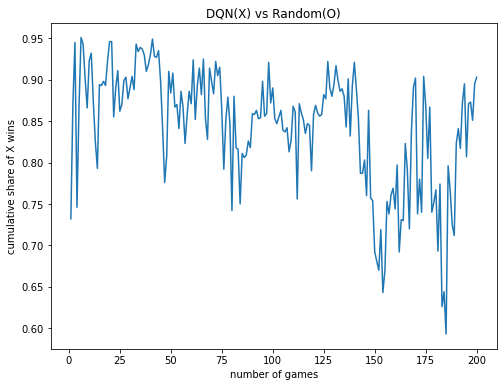

In [21]:
stats = pd.concat(results)
stats.index = stats.epoch
plot_stats(stats, title = 'DQN(X) vs Random(O)')

In [22]:
dqn_game = DQN_Game(env, RandomPlayer("0"), DQN_Player("2"))

num_games_per_epoch = 50
results = []
for i in tqdm_notebook(range(200)):
    stats = dqn_game.playManyGames(num_games_per_epoch, True, True)
    stats = dqn_game.playManyGames(1000, False, False)
    stats = stats.tail(1)
    stats['epoch'] = i + 1
    results.append(stats)

<ipython-input-22-9c489918a9ef>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(200)):


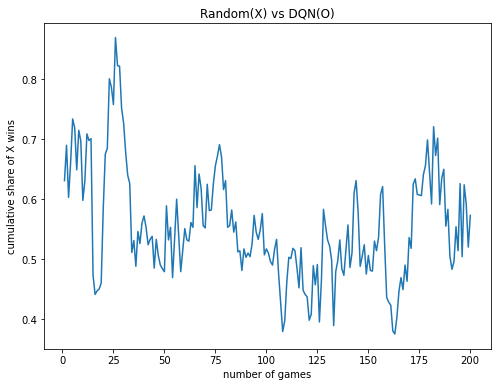

In [23]:
stats = pd.concat(results)
stats.index = stats.epoch
plot_stats(stats, title = 'Random(X) vs DQN(O)')

### А теперь попробуем Double DQN.

In [24]:
class DoubleDQN_Player:
    def __init__(self, value):
        self.value = value
        self.policy_net = DQN()
        self.target_net = DQN()
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.policy_net.parameters(), 0.001)
        self.gamma = 0.8
        self.batch_size = 64
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        self.train_counter = 0 # сколько игр сыграли
        self.target_update = 10 # как часто обновляем target net

    def getValue(self):
        return self.value
    
    def select_greedy_action(self, state, actions):
        with torch.no_grad():
            x = self.policy_net(torch.tensor(get_board(state).astype(np.float32)
                                       ).unsqueeze(0).unsqueeze(1)).squeeze(1)
        x = (x.squeeze(0).data.numpy() + get_mask(actions))
        return np.array(np.unravel_index(np.argmax(x, axis=None), x.shape))
        
    
    def select_action(self, state, actions):
        sample = np.random.rand()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final
                                         ) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, actions)
        else:
            return actions[np.random.randint(0, len(actions))]

    def move(self, actions, state):
        return self.select_action(state, actions)

    def store(self, transition):
        self.memory.store(transition)

    def train(self):
        self.train_counter += 1
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch_next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s.unsqueeze(0) for s in batch_next_state if s is not None])
        
        
        state_action_values = self.policy_net(batch_state.unsqueeze(1)).squeeze(1)
        s_a_vals = []
        for i in range(self.batch_size):
            a = batch_action[i].data.numpy()
            s_a_vals.append(state_action_values[i][a[0], a[1]])
        s_a_vals = torch.stack(s_a_vals)

        
        next_state_values = torch.zeros(self.batch_size)

        next_state_values[non_final_mask] = torch.amax(
            self.target_net(non_final_next_states.unsqueeze(1)).squeeze(1).detach(), dim = (1, 2))

        expected_state_action_values = (next_state_values * self.gamma) + batch_reward

        loss = F.smooth_l1_loss(s_a_vals, expected_state_action_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        if self.train_counter % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

In [25]:
dqn_game = DQN_Game(env, DoubleDQN_Player("2"), RandomPlayer("0"))

num_games_per_epoch = 50
results = []
for i in tqdm_notebook(range(100)):
    stats = dqn_game.playManyGames(num_games_per_epoch, True, True)
    stats = dqn_game.playManyGames(1000, False, False)
    stats = stats.tail(1)
    stats['epoch'] = i + 1
    results.append(stats)

<ipython-input-25-536f0b3134d3>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(100)):


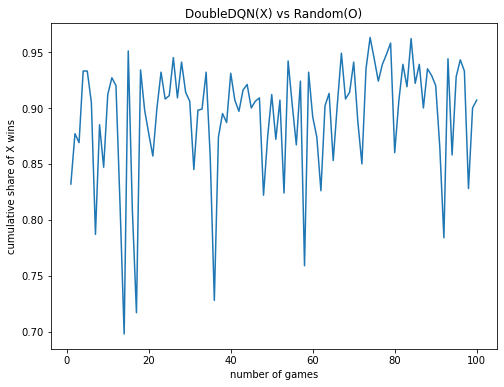

In [26]:
stats = pd.concat(results)
stats.index = stats.epoch
plot_stats(stats, title = 'DoubleDQN(X) vs Random(O)')

In [27]:
dqn_game = DQN_Game(env, RandomPlayer("2"), DoubleDQN_Player("0"))

num_games_per_epoch = 50
results = []
for i in tqdm_notebook(range(100)):
    stats = dqn_game.playManyGames(num_games_per_epoch, True, True)
    stats = dqn_game.playManyGames(1000, False, False)
    stats = stats.tail(1)
    stats['epoch'] = i + 1
    results.append(stats)

<ipython-input-27-4d8bbafb4640>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(100)):


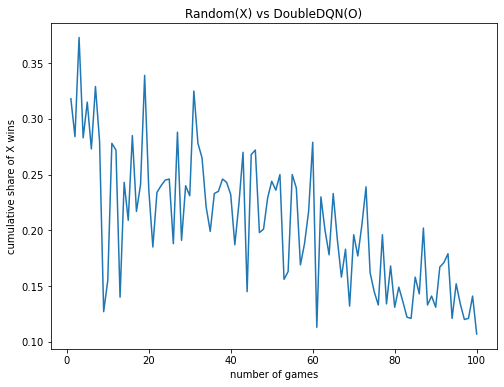

In [28]:
stats = pd.concat(results)
stats.index = stats.epoch
plot_stats(stats, title = 'Random(X) vs DoubleDQN(O)')

### Попробуем сравнить DQN и Double DQN.
Обучим обе модели равное количество эпох и посмотрим, как меняется качество игры каждой.

In [33]:
player1 = DoubleDQN_Player("2")
player2 = DQN_Player("0")

num_games_per_epoch = 50
results = []
for i in tqdm_notebook(range(200)):
    game = DQN_Game(env, player1, RandomPlayer("0"))
    stats = game.playManyGames(num_games_per_epoch, True, True)
    
    game = DQN_Game(env, RandomPlayer("2"), player2)
    stats = game.playManyGames(num_games_per_epoch, True, True)
    
    game = DQN_Game(env, player1, player2)
    
    stats = game.playManyGames(1000, False, False)
    stats = stats.tail(1)
    stats['epoch'] = i + 1
    results.append(stats)

<ipython-input-33-c8ca4b4426a7>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(200)):


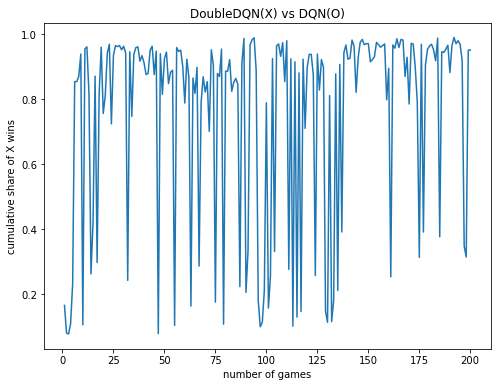

In [34]:
stats = pd.concat(results)
stats.index = stats.epoch
plot_stats(stats, title = 'DoubleDQN(X) vs DQN(O)')

In [35]:
player1 = DQN_Player("2")
player2 = DoubleDQN_Player("0")

num_games_per_epoch = 50
results = []
for i in tqdm_notebook(range(200)):
    game = DQN_Game(env, player1, RandomPlayer("0"))
    stats = game.playManyGames(num_games_per_epoch, True, True)
    
    game = DQN_Game(env, RandomPlayer("2"), player2)
    stats = game.playManyGames(num_games_per_epoch, True, True)
    
    game = DQN_Game(env, player1, player2)
    
    stats = game.playManyGames(1000, False, False)
    stats = stats.tail(1)
    stats['epoch'] = i + 1
    results.append(stats)

<ipython-input-35-be3dfe4b3888>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(200)):


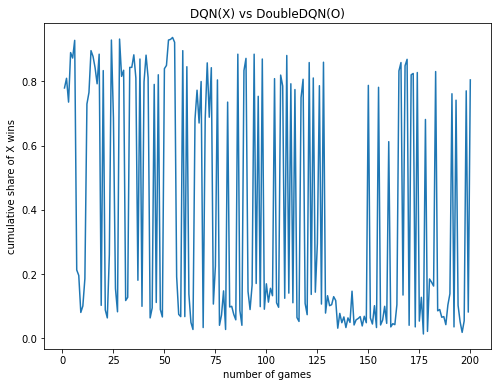

In [36]:
stats = pd.concat(results)
stats.index = stats.epoch
plot_stats(stats, title = 'DQN(X) vs DoubleDQN(O)')